### Diplom thesis
- vyzkouset/najit spravnou **architekturu neuronove site** (LSTM 2-3 vnitrni vrstvy, droup out vyzkouset, zmensovani velikosti vrstev, hyperopt, pouzit Keras?)
- **optimalizace parametru** neuronove site
- provest **uceni neuronove site** (to mozna nechat na konec, provest 20x-30x beh nebo cross validaci -> zprumerovat? at je to pouzitelne ono to vychazi dost ruzne)

In [44]:
import re
import pandas as pd
import numpy as np
import string, os 
import math
from matplotlib import pyplot as plt
import ast
import itertools
from functools import partial
from collections import Counter
from sklearn.metrics import r2_score

from tensorflow.keras.utils import to_categorical
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast
from SmilesPE.pretokenizer import atomwise_tokenizer
import codecs
from SmilesPE.tokenizer import *
from SmilesPE.spe2vec import *
from SmilesPE.pretokenizer import kmer_tokenizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import keras.utils as ku 
from keras import models 
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor

from hyperopt.pyll.base import scope 
from hyperopt import pyll, hp, Trials, fmin, tpe, STATUS_OK

import pickle

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data

In [2]:
df = pd.read_csv('../data/VEGF2_ChEMBL28-10980_pic50_noDuplicate_canSmiles_sln_deepSmiles_selfies_inchi.csv',sep=',')

linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']
for notName in linearNotation_names:
    df[notName+'_length'] = df[notName].str.len()
print(df.shape)
# canonical_smiles_length
dfClean = df.loc[(df['canonical_smiles_length'] >30) & (df['canonical_smiles_length']<80)]
print(dfClean.shape)

(7159, 11)
(7044, 11)


**Pomocne funkce**

In [3]:
def plotPredictReal(predictions,y_test,chem_notation,predictionsPlot_fileName):
        plt.figure(figsize=(10,10))
        plt.scatter(y_test, predictions, c='crimson')
        p1 = max(max( predictions), max(y_test))
        p2 = min(min( predictions), min(y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.title(tokenization+' '+chem_notation, fontsize=15)
        plt.xlabel('True value', fontsize=15)
        plt.ylabel('Prediction', fontsize=15)
        plt.axis('equal')
        plt.show
        plt.savefig(predictionsPlot_fileName)

In [4]:
def saveModelLossPlot(result,chem_notation,modelLossPlot_fileName,tokenization):
    # plot training history
    plt.figure(figsize=(10,10))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('model loss - '+tokenization+' '+chem_notation)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.savefig(modelLossPlot_fileName)

In [5]:
def splitData(list_token, ys, RANDOM_STATE):  
    X_train, X_test, y_train, y_test = train_test_split(list_token, ys, test_size=0.2, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE) # 0.25 x 0.8 = 0.2
    unique= set(list(itertools.chain.from_iterable(X_train)))
    n_unique=len(unique)
    max_index = max(unique)
    if(n_unique > max_index):
        vocabulary_size = n_unique + 5000
    else:
        vocabulary_size = max_index +5000
    return X_train,y_train,X_val,y_val,X_test,y_test,vocabulary_size

In [6]:
def addCharAtBeginningEnd(temp):
    lst=[]
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [7]:
def splitByAtomwiseTokenizer(chem_notation):
    lst=[]
    temp = atomwise_tokenizer(chem_notation)
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [8]:
def removeBeginningInChI(chem_notation,substring):
    res = chem_notation.replace(substring,'')
    return res

In [9]:
def tokenizationBPEChemLinearNotaion(col_name,df):
    fileName = 'data_for_tokenizer/tokenizer-wiki_'+str(col_name)+'.json' 
    fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=fileName)
    return df[col_name].apply(lambda chem_notaion: fast_tokenizer.tokenize(str(chem_notaion)))

In [10]:
def addCharacterStartEndSequenceSplitByCharacters(chem_notation):
    chem_notation = "^" + chem_notation + "$"
    lst = [c for c in chem_notation]
    return lst

In [11]:
def tokenizeChemNotation(chem_notation,col_name): 
    spe_vob= codecs.open('SPE_ChEMBL_'+str(col_name)+'.txt')
    spe = SPE_Tokenizer(spe_vob)
    lst = spe.tokenize(chem_notation)
    lst = lst.split(' ')
    return lst

In [12]:
def splitByKmerTokenizer(chem_notation):
    lst=[]
    temp = kmer_tokenizer(chem_notation, ngram=4, stride=1, remove_last = False, exclusive_tokens = None)
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [13]:
# vytvorit list token id + padding 
def createListTokensId(chem_notation, vocabulary):
    # chem_notation je list tokenu / uz je pocatecni a koncovy znak ^, $
    token_id_list=[]
    for c in chem_notation:
        if(c in vocabulary):
            token_id_list.append(vocabulary[c])
    return token_id_list

In [14]:
def cutVecTokens(x,max_length):
    if(max_length >= len(x)):
        return x
    x = x[:max_length-2]
    x.append('$')
    return x

In [15]:
def create_model(units_embedding,units1,layers,units2,units3,l_rate,cut_length,vocab_size):
    n_features = 1
    # Keras LSTM model
    opt = keras.optimizers.Adam(learning_rate=l_rate)
    model = Sequential()   
    model.add(Embedding(vocab_size,units_embedding, input_length=cut_length))
        
    # model.add(LSTM(units=params['units1'], return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Bidirectional(LSTM(units=units1, input_shape=(cut_length, n_features))))
    model.add(Dropout(rate=0.5))
        
    # Middle layers return sequences
    for i in range(layers-2):
        model.add(Dense(units=units2))
        # model.add(LSTM(units=params['units2'], return_sequences=True))
        model.add(Dropout(rate=0.5))
        
    # Last layer doesn't return anything        
    model.add(Dense(units=units3))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=opt,metrics=['mse'])
    # model.summary()

    return model

In [42]:
# objective funkce pro hyperopt s cross validaci
def objective(params, X_train, y_train, n_patience, idx, cut_length,vocab_size,RANDOM_STATE):
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=n_patience)
    model_nn = KerasRegressor(build_fn = create_model,**params, cut_length=cut_length,vocab_size=vocab_size,  epochs = 400, verbose = 0)
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model_nn, X_train, y_train,scoring='neg_mean_squared_error', cv=kfold,fit_params={'callbacks':[es]},error_score='raise')
    score = scores.mean()
    std = scores.std()
    loss = -score
    print('params:\t',params)
    print('score:\t',loss)
    print('std:\t',std)
    # Dictionary with information for evaluation
    return {
        'loss': loss,
        'params': params,
        'std' : std,
        'status': STATUS_OK }

In [17]:
def tokenizeTokenIndex(df,linearNotation_name,tokenization,lengths_lst_tokenIdxs,j):
    substring = 'InChI=1S/'
    df['inchi'] = df['inchi'].apply(lambda chem_notation: removeBeginningInChI(chem_notation,substring))
    col_name = linearNotation_name
    token_col_name = col_name+'_tokens'
    tokenIndex_col_name = col_name+'_tokenIndexList'

    if(tokenization == 'atom'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: splitByAtomwiseTokenizer(chem_notation))
    elif(tokenization == 'bpe'):
        df[token_col_name] = tokenizationBPEChemLinearNotaion(col_name,df)
        df[token_col_name] = df[token_col_name].apply(lambda lst_tokens: addCharAtBeginningEnd(lst_tokens))
    elif(tokenization == 'char'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: addCharacterStartEndSequenceSplitByCharacters(chem_notation))
    elif(tokenization == 'spe'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: tokenizeChemNotation(chem_notation,col_name))
    elif(tokenization == 'kmer'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: splitByKmerTokenizer(chem_notation))

    max_length = lengths_lst_tokenIdxs[tokenization][j]
    df[token_col_name] = df[token_col_name].apply(lambda x: cutVecTokens(x,max_length))
    print(max_length)
    CHEM_NOTATION_CHARS = set(df[token_col_name].apply(list).sum())
    print(len(CHEM_NOTATION_CHARS))
    
    if(len(CHEM_NOTATION_CHARS) * max_length > 100000):
        tempN = ((len(CHEM_NOTATION_CHARS) * max_length)-100000)/max_length
        n = math.floor(len(CHEM_NOTATION_CHARS)-tempN)
        n = len(CHEM_NOTATION_CHARS)-n
        print('n =',n)
        
        temp = df[token_col_name].tolist()
        flat_list = [item for sublist in temp for item in sublist]
        count_flatList = Counter(flat_list)
        keysSort = [pair[0] for pair in sorted(count_flatList.items(), key=lambda item: item[1],reverse=False)]
        
        print(n)
        for i in range(n):
            del count_flatList[keysSort[i]]
        CHEM_NOTATION_CHARS = count_flatList.keys()
        print('nova delka: ',len(CHEM_NOTATION_CHARS))
    
    vocabulary = {c: i+2 for i,c in enumerate(set(CHEM_NOTATION_CHARS))}
    df[tokenIndex_col_name] = df[token_col_name].apply(lambda chem_notation: createListTokensId(chem_notation, vocabulary))
    
    res = df[tokenIndex_col_name].apply(lambda tokenIndex: tokenIndex).tolist()
    vector_with_padding = pad_sequences(res, maxlen=max_length, padding='post', truncating='post')
    df[tokenIndex_col_name] = [vector_with_padding[i] for i in range(len(vector_with_padding))]    
    
    return np.array(df[tokenIndex_col_name].tolist())

In [18]:
# vytvoreni modelu s tunnenim parametru
def builtModelBestParams(params,cut_length,vocab_size):
    n_features = 1
    opt = keras.optimizers.Adam(learning_rate=params['l_rate'])
    
    model = Sequential()
    model.add(Embedding(vocab_size,params['units_embedding'], input_length=cut_length))
    model.add(Bidirectional(LSTM(units=params['units1'], input_shape=(cut_length, n_features))))
    model.add(Dropout(rate=0.5))

    for i in range(params['layers']-2):
        model.add(Dense(units=params['units2']))
        model.add(Dropout(rate=0.5))
        
    model.add(Dense(units=params['units3']))
    model.add(Dropout(rate=0.5))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=opt,metrics=['mse'])
    # model.summary()
    return model

In [45]:
def builtModelWithBestParams(best_params,cut_length,cut_data,j,vocab_size,bestModel_fileName,modelHistory_fileName, bestParams_fileName,predictions_fileName,modelLossPlot_fileName,predictionsPlot_fileName,n_patience,encoding,chem_notation,tokenization,X_train,y_train,X_val,y_val,X_test,y_test):
    # print('best params: ',best_params,'\ncut length: ',cut_length,'\nvocab_size:',vocab_size)
    model = builtModelBestParams(best_params,cut_length,vocab_size)
    mc = ModelCheckpoint(bestModel_fileName, monitor='val_loss', mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=n_patience)
    # train model
    result = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=400,verbose=0, callbacks=[es,mc])
    # store information
    # ----------------------------------------- BEST MODEL ---------------------------------------
    best_model = models.load_model(bestModel_fileName)
    # model prediction
    y_pred = best_model.predict(X_test)
    results_eval = best_model.evaluate(X_val, y_val)
    print('\nn_patience:  ', n_patience)
    print('max_length:  ',cut_length)
    print('results:',results_eval ,end='\n')
    plotPredictReal(y_pred, y_test,chem_notation,predictionsPlot_fileName)
    saveModelLossPlot(result,chem_notation,modelLossPlot_fileName,tokenization)
    
    #store information
    # ----------------------------------------- HISTORY ---------------------------------------
    with open(modelHistory_fileName, 'w') as f:
        np.save(modelHistory_fileName,result.history)
    # ----------------------------------------- BEST PARAMS ---------------------------------------
    a_file = open(bestParams_fileName, "wb")
    pickle.dump(best_params, a_file)
    a_file.close()
    # ----------------------------------------- PREDICTIONS ---------------------------------------
    prediction = pd.DataFrame(y_pred, columns=['predictions']).to_csv(predictions_fileName)
    
    r2 = r2_score(y_test, y_pred)
    return [results_eval,r2]

# Trenovani site

-----------------------------------------------------------------------------
atom
chem notation:   canonical_smiles
cut_length  60
nUnitsEmbedding [64]
unitsLst
 [16, 32, 64]
60
42
Epoch 00004: early stopping                          
Epoch 00007: early stopping                          
Epoch 00002: early stopping                          
Epoch 00010: early stopping                          
Epoch 00004: early stopping                          
Epoch 00012: early stopping                          
Epoch 00011: early stopping                          
Epoch 00010: early stopping                          
Epoch 00009: early stopping                          
Epoch 00006: early stopping                          
params:	                                             
{'l_rate': 0.10922500544317164, 'layers': 2, 'units1': 64, 'units2': 16, 'units3': 64, 'units_embedding': 64}
score:	                                              
2.1384077567825748                                   
std:	 

KeyboardInterrupt: 

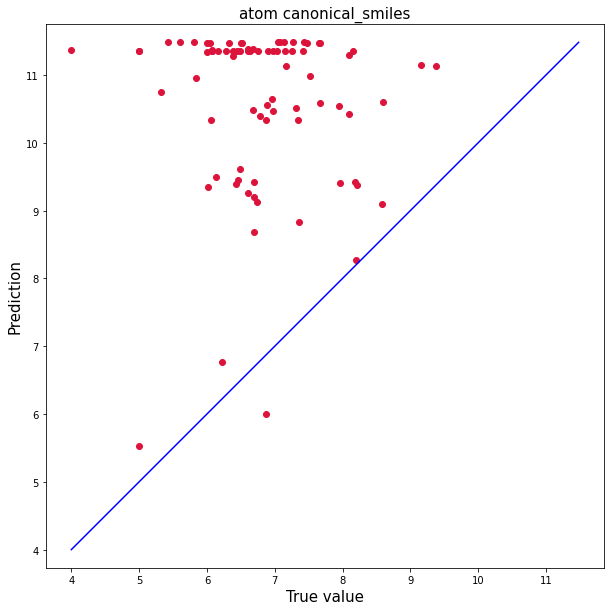

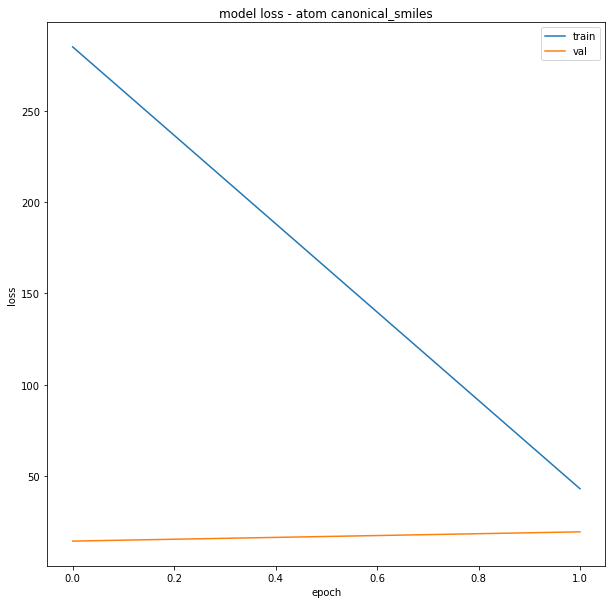

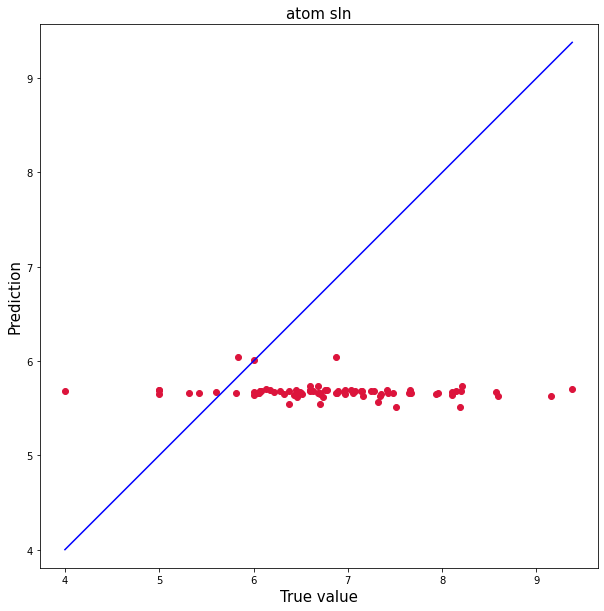

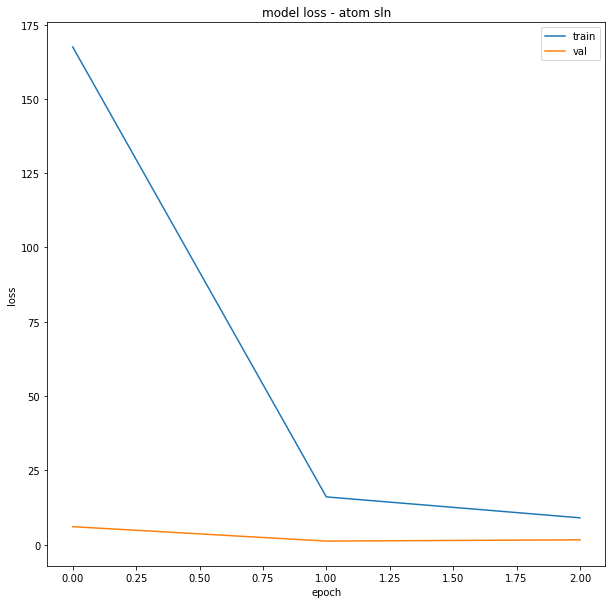

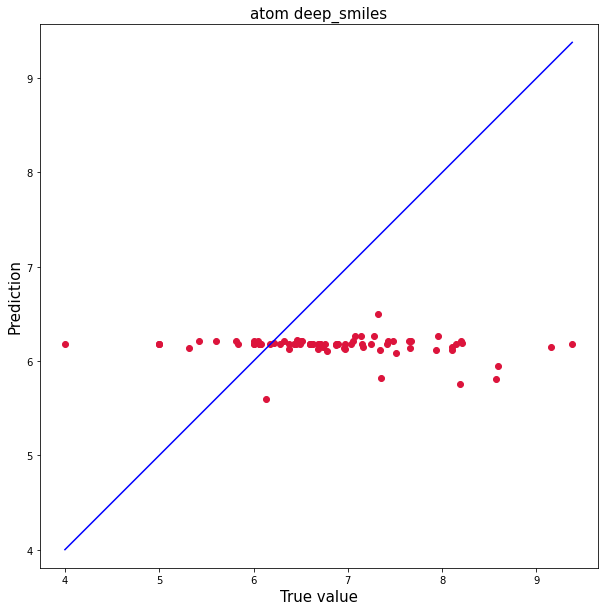

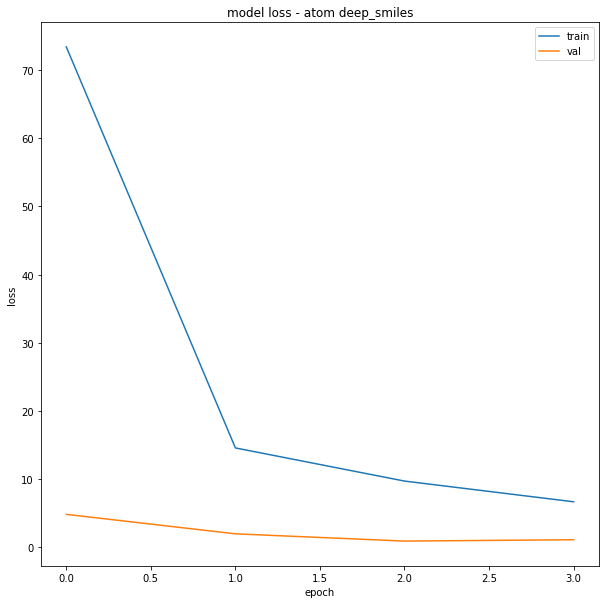

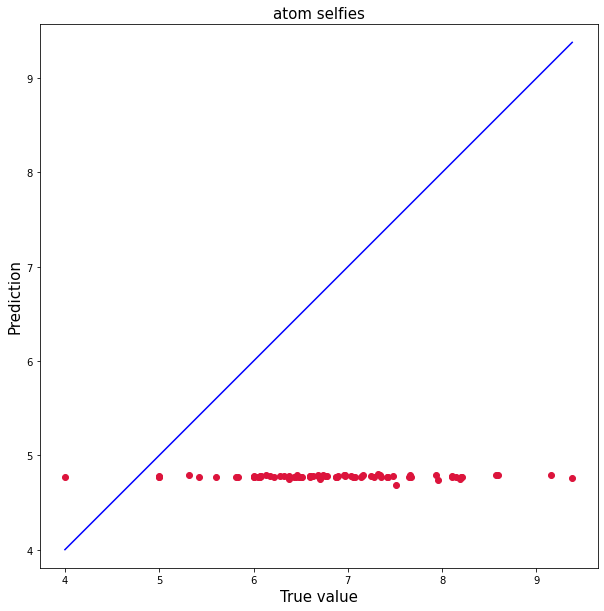

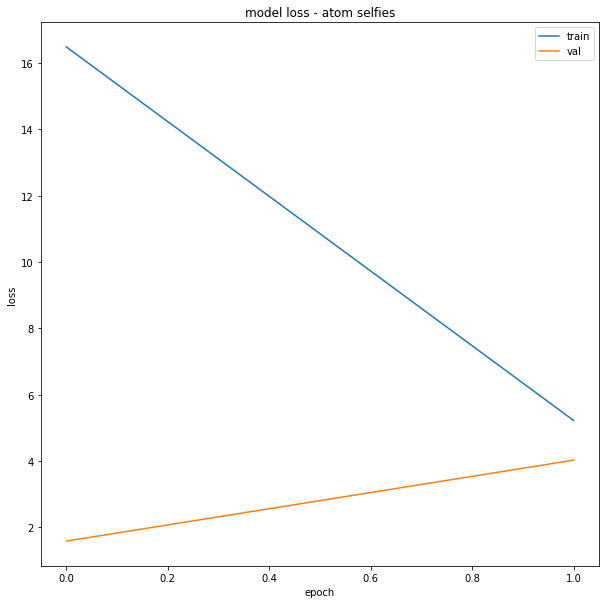

In [47]:
# budu delat postupne po tokenizacich, abych to mohla kontrolovat
tokenization_names = ['atom','bpe','char','spe','kmer']
linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']
# best_params={'layers': 3, 'l_rate': 0.01, 'units1': 70, 'units2': 50, 'units3': 30,'units_embedding':130}

encoding = 'tokenIndexVector'
m_e=30
n_patience = 20
RANDOM_STATE=42

ys = np.array(dfClean['value'].tolist())

df_score = {'tokenization': ['empty'], 'chem_notation': ['empty'],'score_cross_val':['empty'],'std_cross_val':['empty'],'loss_mse':['empty'],'metric_mse':['empty'],'r2':['empty']}
df_score = pd.DataFrame(df_score)

fileNameScore = '../data/final_results/'+encoding+'/scoreCrossVal.csv'
# kontrola, jestli soubor neexistuje, kdyz poustim znova
if os.path.exists(fileNameScore):
    os.remove(fileNameScore)
df_score.to_csv(fileNameScore,sep=',',header=True,index=False)

# # pocty tokenu - urcene, poradi dle linearNoation_names
#      canonical_smiles, sln, deep_smiles, selfies, inchi
lengths_lst_tokenIdxs = {   'atom':[60,90,65,62,160],
                            'char':[62,105,70,300,160],
                            'kmer':[60,92,65,60,160],
                            'bpe':[30,62,24,125,90],
                            'spe':[13,8,7,31,43]}

or_unitsLst = [16, 32, 64, 128]


for i in range(len(tokenization_names)):
    tokenization = tokenization_names[i]
    print('-----------------------------------------------------------------------------\n'+tokenization)
    df_score['tokenization'][0] = tokenization
    
    difSmallNum=5000
    for j in range(len(linearNotation_names)):
        chem_notation = linearNotation_names[j]
        print('chem notation:  ',chem_notation)
        df_score['chem_notation'][0] = chem_notation
        
        cut_length = lengths_lst_tokenIdxs[tokenization][j]

        # vybrani poctu neuronu pro vstupni vrstvu
        for u in range(len(or_unitsLst)):
            if(or_unitsLst[u]>cut_length):
                difGreatNum = abs(or_unitsLst[u] - cut_length)
                if(u!=0):
                    difSmallNum = abs(or_unitsLst[u-1] - cut_length)
                if(difGreatNum <= difSmallNum):    
                    nUnitsEmbedding = [or_unitsLst[u]]
                    unitsLst = or_unitsLst[:(u+1)]
                    break
                else:
                    nUnitsEmbedding = [or_unitsLst[u-1]]
                    unitsLst = or_unitsLst[:(u)]
                    break
            elif(or_unitsLst[u]==cut_length or u==(len(or_unitsLst)-1)):
                nUnitsEmbedding = [or_unitsLst[u]]
                unitsLst = or_unitsLst[:(u+1)]
                break
        
        print('cut_length ',cut_length)
        print('nUnitsEmbedding',nUnitsEmbedding)
        print('unitsLst\n',unitsLst)
        
        space = {'units_embedding'    : hp.choice('units_embedding', nUnitsEmbedding),
         'units1'             : hp.choice('units1', unitsLst),
         'units2'             : hp.choice('units2', unitsLst),
         'units3'             : hp.choice('units3', unitsLst),
         'layers'             : scope.int(hp.quniform('layers',2,3,1)),
         'l_rate'             : hp.loguniform('l_rate', np.log(0.01), np.log(0.2))
        }
        
        data = tokenizeTokenIndex(dfClean.copy(),chem_notation,tokenization, lengths_lst_tokenIdxs,j) 
        X_train,y_train,X_val,y_val,X_test,y_test,vocab_size = splitData(data, ys, RANDOM_STATE)
                
        startName = '../data/final_results/'+encoding+'/'+tokenization+'/'
        bestModel_fileName = startName+'bestModels/'+chem_notation+'.h5'
        modelHistory_fileName = startName+'history/'+chem_notation+'.npy'
        modelLossPlot_fileName = startName+'lossPlot/'+chem_notation+'.png'
        bestParams_fileName = startName+'bestParams/'+chem_notation+'.pkl'
        predictions_fileName = startName+'predictions/'+chem_notation+'.csv'
        predictionsPlot_fileName = startName+'predictionsPlot/'+chem_notation+'.png'
        
        
        # zatim mam jen chemicke linearni zapisy
        fmin_objective = partial(objective, n_patience = n_patience, idx=j,vocab_size = vocab_size ,cut_length = cut_length,X_train=X_train,y_train=y_train,RANDOM_STATE=RANDOM_STATE)
        
        bayes_trials = Trials()
        best = fmin(fn = fmin_objective, space = space, algo = tpe.suggest, max_evals = m_e, trials = bayes_trials)#, rstate = np.random.RandomState(50))

        best_loss = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['loss']
        best_std = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['std']
        best_params = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]['params']
        print('best params:\n',best_params,'\nbest loss:\n',best_loss,'\nbest std:\n',best_std,end = '\n')
    
        df_score['score_cross_val'][0] = best_loss
        df_score['std_cross_val'][0] = best_std
        
        results_eval,r2 = builtModelWithBestParams(best_params,cut_length,data,j,vocab_size,bestModel_fileName,modelHistory_fileName, bestParams_fileName,
                                 predictions_fileName,modelLossPlot_fileName,predictionsPlot_fileName,n_patience,encoding,chem_notation,
                                 tokenization,X_train,y_train,X_val,y_val,X_test,y_test)
        
        df_score['loss_mse'][0] = results_eval[0]
        df_score['metric_mse'][0] = results_eval[1]
        df_score['r2'][0] = r2
        df_score.to_csv(fileNameScore, mode='a', index=False, header=False)